!pip install -U transformers datasets --quiet
!pip uninstall -y peft
!pip install peft --upgrade --quiet  # Optional, to make sure it's compatible
import os
os._exit(0)  # Force restart


In [ ]:
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer as TokenizerRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import time
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2LMHeadModel, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns
import math
import torch.nn as nn
from torch.utils.data import TensorDataset

## Task 1: Understanding the Limitations of RNNs and the Need for Transformers

import os
os._exit(0) 

In [32]:
df = pd.read_excel('/kaggle/input/students-anxiety-and-depression-dataset/dataset.xlsx')
df.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


In [33]:
df['text'] = df['text'].fillna('').astype(str).apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x.lower()))
df = df[df['label'].notna()]
y = df['label'].astype(int)

In [34]:
tokenizer_rnn = TokenizerRNN()
tokenizer_rnn.fit_on_texts(df['text'])
X_rnn = tokenizer_rnn.texts_to_sequences(df['text'])
X_rnn = pad_sequences(X_rnn)
y_rnn = df['label'].values

In [35]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

In [36]:
model_rnn = Sequential([
    Embedding(input_dim=len(tokenizer_rnn.word_index)+1, output_dim=128, input_length=X_rnn.shape[1]),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_rnn = time.time()
rnn_history = model_rnn.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=5, batch_size=16)
end_rnn = time.time()
rnn_time = end_rnn - start_rnn
print(f"RNN training time: {rnn_time:.2f} seconds")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


349/349 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8983 - loss: 0.3158 - val_accuracy: 0.9699 - val_loss: 0.1049
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9765 - loss: 0.0756 - val_accuracy: 0.9549 - val_loss: 0.1385
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9889 - loss: 0.0370 - val_accuracy: 0.9713 - val_loss: 0.1143
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9951 - loss: 0.0171 - val_accuracy: 0.9721 - val_loss: 0.0975
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9491 - val_loss: 0.1460
RNN training time: 15.15 seconds


In [37]:
rnn_preds = (model_rnn.predict(X_test_rnn) > 0.5).astype(int)
rnn_acc = accuracy_score(y_test_rnn, rnn_preds)
rnn_f1 = f1_score(y_test_rnn, rnn_preds)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [38]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
texts_bert = df['text'].tolist()
labels_bert = df['label'].tolist()
train_texts_bert, val_texts_bert, train_labels_bert, val_labels_bert = train_test_split(texts_bert, labels_bert, test_size=0.2)

class BERTTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        encoding = tokenizer_bert(self.texts[idx], return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx])
        }

train_ds_bert = BERTTextDataset(train_texts_bert, train_labels_bert)
val_ds_bert = BERTTextDataset(val_texts_bert, val_labels_bert)
train_loader_bert = DataLoader(train_ds_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_ds_bert, batch_size=32)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [39]:
class BERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 1)
    def forward(self, input_ids, attention_mask):
        pooled = self.bert(input_ids, attention_mask).pooler_output
        return torch.sigmoid(self.fc(pooled)).squeeze()

model_bert = BERTClassifier().to("cuda")
optimizer_bert = torch.optim.Adam(model_bert.parameters(), lr=2e-5)
criterion = nn.BCELoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [40]:
model_bert.train()
start_bert = time.time()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader_bert:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['label'].float().to("cuda")

        optimizer_bert.zero_grad()
        outputs = model_bert(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_bert.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader_bert):.4f}")
end_bert = time.time()
transformer_time = end_bert - start_bert

Epoch 1 Loss: 0.1196
Epoch 2 Loss: 0.0465
Epoch 3 Loss: 0.0348


In [41]:
model_bert.eval()
preds_bert, truths_bert = [], []
with torch.no_grad():
    for batch in val_loader_bert:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['label'].to("cuda")

        outputs = model_bert(input_ids, attention_mask)
        pred_labels = (outputs > 0.5).int()
        preds_bert.extend(pred_labels.cpu().numpy())
        truths_bert.extend(labels.cpu().numpy())

bert_acc = accuracy_score(truths_bert, preds_bert)
bert_f1 = f1_score(truths_bert, preds_bert)

print("Transformer Accuracy:", accuracy_score(truths_bert, preds_bert))
print("Transformer F1:", f1_score(truths_bert, preds_bert))
print(f"RNN training time: {transformer_time:.2f} seconds")

Transformer Accuracy: 0.9921203438395415
Transformer F1: 0.9605734767025089


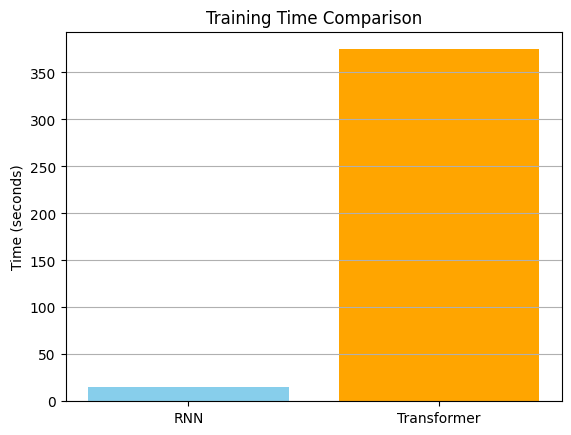

In [42]:
import matplotlib.pyplot as plt

models = ['RNN', 'Transformer']
training_times = [rnn_time, transformer_time]

plt.bar(models, training_times, color=['skyblue', 'orange'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(True, axis='y')
plt.show()

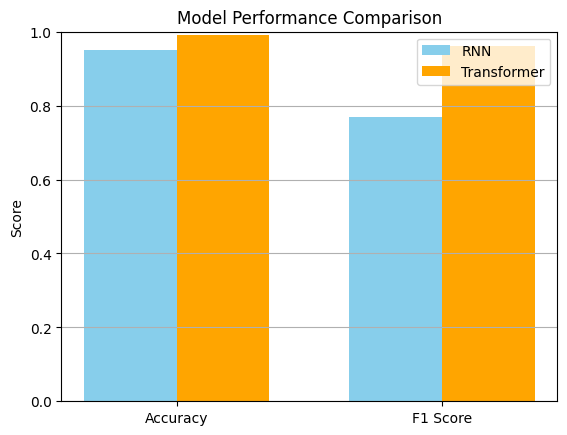

In [43]:
metrics = ['Accuracy', 'F1 Score']
rnn_scores = [rnn_acc, rnn_f1]
transformer_scores = [bert_acc, bert_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rnn_scores, width, label='RNN', color='skyblue')
ax.bar(x + width/2, transformer_scores, width, label='Transformer', color='orange')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, axis='y')
plt.ylim(0, 1.0)
plt.show()

## Task 2: Self-Attention Mechanism

In [46]:
df_toy = pd.read_csv('/kaggle/input/toy-dataset/toy_dataset.csv')

In [47]:
def row_to_text(row):
    return f"A {row['Age']}-year-old {row['Gender'].lower()} from {row['City']} earning {row['Income']} is {'ill' if row['Illness'] == 'Yes' else 'healthy'}."

In [48]:
sample_sentence = row_to_text(df_toy.iloc[0])
sentence_tokens = sample_sentence.split()
print("Tokens:", sentence_tokens)

Tokens: ['A', '41-year-old', 'male', 'from', 'Dallas', 'earning', '40367.0', 'is', 'healthy.']


In [49]:
#  random token embeddings
embedding_dim = 8
token_embeddings = torch.randn(len(sentence_tokens), embedding_dim) 

Q = K = V = token_embeddings.unsqueeze(0)


In [50]:
# Self-attention function
def self_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights

output, attn_weights = self_attention(Q, K, V)

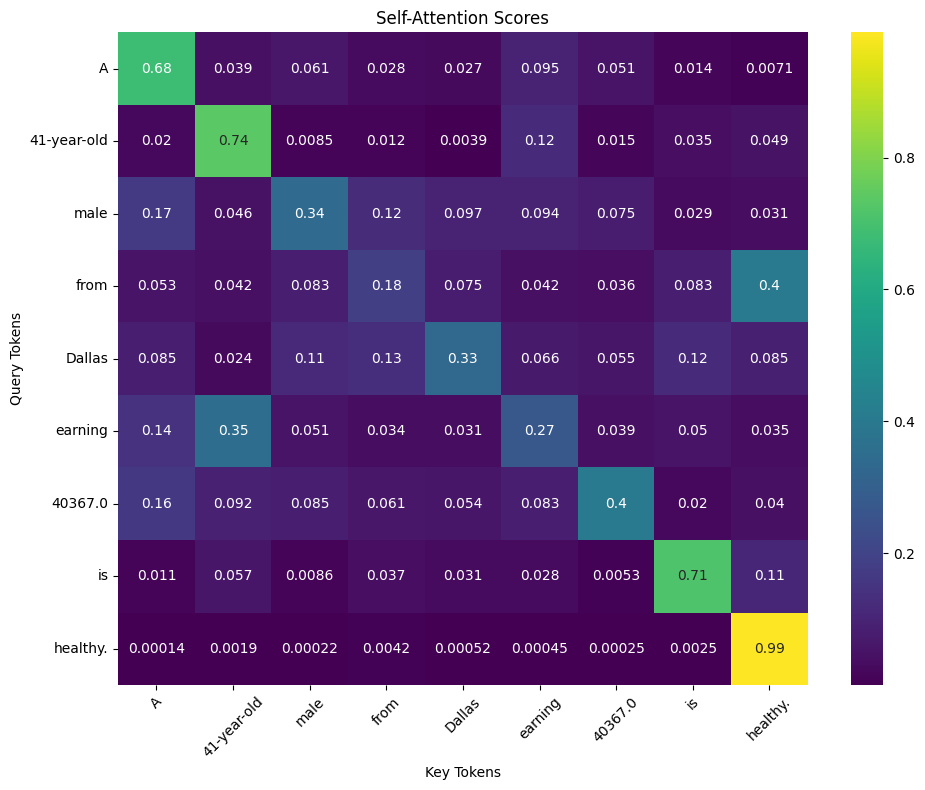

In [51]:
attn_weights_np = attn_weights.squeeze(0).detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights_np, xticklabels=sentence_tokens, yticklabels=sentence_tokens, cmap='viridis', annot=True)
plt.title("Self-Attention Scores")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Task 3: Introduction to Transformer Architecture

In [54]:
def positional_encoding(seq_len, d_model):
    PE = torch.zeros(seq_len, d_model)
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            PE[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
            if i + 1 < d_model:
                PE[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
    return PE.unsqueeze(0)  # (1, seq_len, d_model)

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.size()
        Q = self.linear_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        weights = torch.softmax(scores, dim=-1)
        attention = torch.matmul(weights, V)
        concat = attention.transpose(1, 2).contiguous().view(B, T, C)
        return self.fc_out(concat)

In [56]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [57]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout(self.attn(x)))
        x = self.norm2(x + self.dropout(self.ff(x)))
        return x

In [58]:
class SentimentTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_classes, max_len):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = positional_encoding(max_len, d_model)
        self.encoder = TransformerEncoderLayer(d_model, num_heads, d_ff)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, T = x.size()
        x = self.embed(x) + self.pos_enc[:, :T, :].to(x.device)
        x = self.encoder(x)
        x = x.transpose(1, 2)  # (B, d_model, T)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)

In [59]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
encodings = tokenizer_bert(df['text'].tolist(), truncation=True, padding='max_length', max_length=100)
X_transformer = np.array(encodings['input_ids'])
y = df['label'].values

In [60]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_transformer, y, test_size=0.2, random_state=42)

In [61]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [62]:
train_dataset = TensorDataset(
    torch.tensor(X_train_tf, dtype=torch.long),
    torch.tensor(y_train_tf, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataset = TensorDataset(
    torch.tensor(X_test_tf, dtype=torch.long),
    torch.tensor(y_test_tf, dtype=torch.long)
)
val_loader = DataLoader(val_dataset, batch_size=32)

model = SentimentTransformerClassifier(
    vocab_size=30522, d_model=128, num_heads=8, d_ff=512, num_classes=2, max_len=100
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        x, y = [t.to(device) for t in batch]
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).tolist())
        all_labels.extend(y.tolist())

    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = [t.to(device) for t in batch]
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

Epoch 1: Train Loss=0.3386, Train Acc=0.8972, Val Loss=0.3453, Val Acc=0.8861
Epoch 2: Train Loss=0.2168, Train Acc=0.9321, Val Loss=0.1441, Val Acc=0.9606
Epoch 3: Train Loss=0.1094, Train Acc=0.9726, Val Loss=0.0778, Val Acc=0.9814
Epoch 4: Train Loss=0.0625, Train Acc=0.9844, Val Loss=0.0638, Val Acc=0.9871
Epoch 5: Train Loss=0.0538, Train Acc=0.9871, Val Loss=0.0609, Val Acc=0.9871
Epoch 6: Train Loss=0.0505, Train Acc=0.9878, Val Loss=0.0607, Val Acc=0.9878
Epoch 7: Train Loss=0.0454, Train Acc=0.9898, Val Loss=0.0606, Val Acc=0.9878
Epoch 8: Train Loss=0.0406, Train Acc=0.9910, Val Loss=0.0620, Val Acc=0.9885
Epoch 9: Train Loss=0.0376, Train Acc=0.9914, Val Loss=0.0637, Val Acc=0.9878
Epoch 10: Train Loss=0.0328, Train Acc=0.9923, Val Loss=0.0649, Val Acc=0.9878


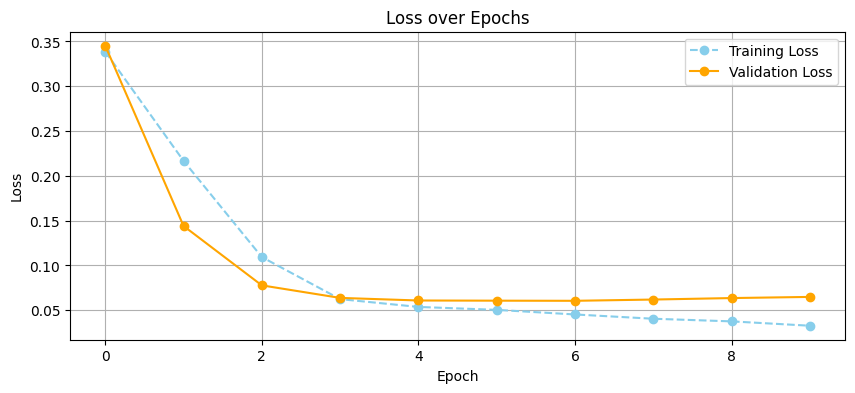

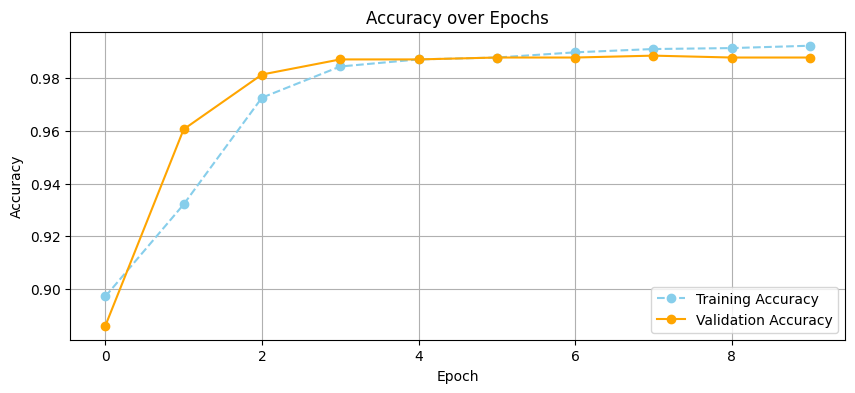

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss', linestyle='--', marker='o', color='skyblue')
plt.plot(val_losses, label='Validation Loss', linestyle='-', marker='o', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Training Accuracy', linestyle='--', marker='o', color='skyblue')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='-', marker='o', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Task 4: Pretrained Language Models (BERT, GPT, T5)

In [67]:
class BERTTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        encoding = tokenizer_bert(self.texts[idx], return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx])
        }

class BERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 1)
    def forward(self, input_ids, attention_mask):
        pooled = self.bert(input_ids, attention_mask).pooler_output
        return torch.sigmoid(self.fc(pooled)).squeeze()

In [68]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
texts_bert = df['text'].tolist()
labels_bert = df['label'].tolist()
train_texts_bert, val_texts_bert, train_labels_bert, val_labels_bert = train_test_split(texts_bert, labels_bert, test_size=0.2)

train_ds_bert = BERTTextDataset(train_texts_bert, train_labels_bert)
val_ds_bert = BERTTextDataset(val_texts_bert, val_labels_bert)
train_loader_bert = DataLoader(train_ds_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_ds_bert, batch_size=32)

In [69]:
# Train BERT
model_bert = BERTClassifier().to("cuda")
optimizer_bert = torch.optim.Adam(model_bert.parameters(), lr=2e-5)
criterion = nn.BCELoss()
model_bert.train()
start_bert = time.time()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader_bert:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['label'].float().to("cuda")
        optimizer_bert.zero_grad()
        outputs = model_bert(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_bert.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader_bert):.4f}")
end_bert = time.time()

Epoch 1 Loss: 0.1306
Epoch 2 Loss: 0.0408
Epoch 3 Loss: 0.0249


In [70]:
model_bert.eval()
preds_bert, truths_bert = [], []
with torch.no_grad():
    for batch in val_loader_bert:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['label'].to("cuda")
        outputs = model_bert(input_ids, attention_mask)
        pred_labels = (outputs > 0.5).int()
        preds_bert.extend(pred_labels.cpu().numpy())
        truths_bert.extend(labels.cpu().numpy())

print("BERT Accuracy:", accuracy_score(truths_bert, preds_bert))
print("BERT F1:", f1_score(truths_bert, preds_bert))

BERT Accuracy: 0.9914040114613181
BERT F1: 0.96


In [71]:
def create_prompt(row):
    label = "<|positive|>" if row['label'] == 1 else "<|negative|>"
    return f"{label} {row['text']}"

df['prompt'] = df.apply(create_prompt, axis=1)
train_texts, val_texts = train_test_split(df['prompt'].tolist(), test_size=0.2)

In [72]:
tokenizer_gpt = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

def encode_lines(lines):
    return tokenizer_gpt(lines, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

train_encodings = encode_lines(train_texts)
val_encodings = encode_lines(val_texts)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [73]:
class GPTDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attn_mask = encodings['attention_mask']
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_mask[idx],
            'labels': self.input_ids[idx]
        }

train_dataset = GPTDataset(train_encodings)
val_dataset = GPTDataset(val_encodings)

In [74]:
model_gpt = GPT2LMHeadModel.from_pretrained("gpt2")
model_gpt.resize_token_embeddings(len(tokenizer_gpt))  # In case new tokens were added
model_gpt = model_gpt.to("cuda")

training_args = TrainingArguments(
    output_dir="./gpt2_sentiment_noeval",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_steps=500,
    logging_steps=100,
    logging_dir="./logs",
    save_total_limit=1,
    report_to="none"
)

trainer_gpt = Trainer(
    model=model_gpt,
    args=training_args,
    train_dataset=train_dataset,
)

trainer_gpt.train()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,0.439600
200,0.322000
300,0.328900
400,0.329900
500,0.295900
600,0.329900
700,0.310100
800,0.285500
900,0.288700
1000,0.310100


TrainOutput(global_step=2094, training_loss=0.3037502804367226, metrics={'train_runtime': 419.0006, 'train_samples_per_second': 39.981, 'train_steps_per_second': 4.998, 'total_flos': 1094291030016000.0, 'train_loss': 0.3037502804367226, 'epoch': 3.0})

In [75]:
trainer_gpt.train()

Step,Training Loss
100,0.261600
200,0.252800
300,0.263700
400,0.265100
500,0.246100
600,0.280200
700,0.265000
800,0.242100
900,0.249100
1000,0.269600


TrainOutput(global_step=2094, training_loss=0.25564672475557954, metrics={'train_runtime': 420.5651, 'train_samples_per_second': 39.832, 'train_steps_per_second': 4.979, 'total_flos': 1094291030016000.0, 'train_loss': 0.25564672475557954, 'epoch': 3.0})

In [76]:
seed_text = "<|positive|> I feel so lucky"
input_ids = tokenizer_gpt.encode(seed_text, return_tensors="pt").to("cuda")
output = model_gpt.generate(input_ids, max_length=60, num_beams=5, no_repeat_ngram_size=2)
print(tokenizer_gpt.decode(output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|positive|> I feel so lucky to be able to live in a city that is not as beautiful as my homeland as it is now


In [77]:
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-small")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small").to("cuda")

sample_lines =  df['text'].dropna().astype(str).tolist()[:3]

prompts = [f"translate English to French: {line}" for line in sample_lines]

french_translations = []
for line in prompts:
    input_ids = tokenizer_t5.encode(line, return_tensors="pt", truncation=True, max_length=128).to("cuda")
    output_ids = model_t5.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translation = tokenizer_t5.decode(output_ids[0], skip_special_tokens=True)
    french_translations.append(translation)
    
for i, (original, translated) in enumerate(zip(sample_lines, french_translations), 1):
    print(f"{i}. English: {original}")
    print(f"   French : {translated}\n")

1. English: oh my gosh
   French : oh, ma gosh

2. English: trouble sleeping confused mind restless heart all out of tune
   French : trouble de dormir confondu cur inconnu et inconnu

3. English: all wrong back off dear forward doubt stay in a restless and restless place
   French : all wrong back off cher avant doute rester dans un endroit sans repos et sans repos



In [79]:
transformer_time = end_bert - start_bert
print(f"BERT Training Time: {transformer_time:.2f} seconds")

BERT Training Time: 373.76 seconds
